# Jupyter notebook for debugging

In [1]:
%load_ext autoreload
%autoreload 2

# Copied from `train` function in train_simple.py:L78
import yaml

device = 'cpu'
hyp = 'data/hyps/hyp.scratch-low.yaml'

with open(hyp, errors="ignore") as f:
    hyp = yaml.safe_load(f)  # load hyps dict

In [2]:
from models.yolo import Model
from utils.general import check_dataset

cfg = 'models/yolov5n_kaist-rgbt.yaml'
data = 'data/kaist-rgbt.yaml'
data_dict = check_dataset(data)

nc = int(data_dict["nc"])  # number of classes
model = Model(cfg, ch=3, nc=nc, anchors=hyp.get("anchors")).to(device)  # create

Overriding model.yaml nc=1 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      3520  models.common.MultiStreamConv           [3, 16, 6, 2, 2]              
  1                -1  1      9344  models.common.MultiStreamConv           [16, 32, 3, 2]                
  2                -1  1      9600  models.common.MultiStreamC3             [32, 32, 1]                   
  3                -1  1         0  models.common.Fusion                    ['concat', 2]                 
  4                -1  1      4224  models.common.Conv                      [64, 64, 1, 1]                
  5                -1  1     36992  models.common.Conv                      [64, 64, 3, 2]                
  6                -1  2     29184  models.common.C3                        [64, 64, 2]                   
  7                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               

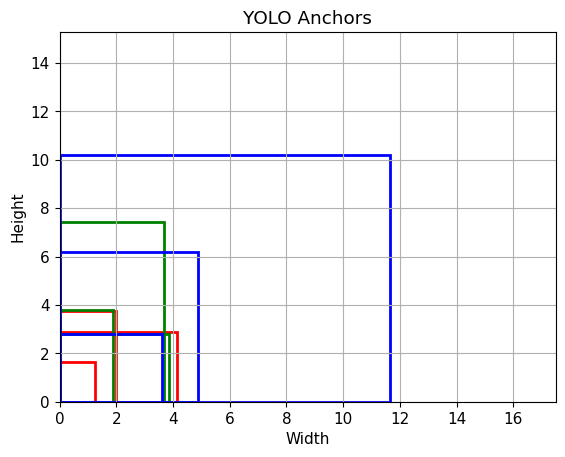

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

# Extract anchors from the model
anchors = model.model[-1].anchors

# # Print anchors to ensure they are loaded correctly
# print(anchors)

# Convert to numpy array if necessary
anchors = anchors.detach().cpu().numpy()

# Enable inline plotting if using Jupyter
# %matplotlib inline  # Use %matplotlib notebook for interactive plots

# Create a figure and axis
fig, ax = plt.subplots()

# Colors for different sets of anchors
colors = ['r', 'g', 'b']

# Plot each set of anchors
for i, anchor_set in enumerate(anchors):
    for anchor in anchor_set:
        rect = plt.Rectangle((0, 0), anchor[0], anchor[1], fill=False, edgecolor=colors[i], linewidth=2)
        ax.add_patch(rect)

# Setting the plot limits to accommodate all anchors
plt.xlim(0, max(anchors[:, :, 0].flatten()) * 1.5)
plt.ylim(0, max(anchors[:, :, 1].flatten()) * 1.5)
plt.xlabel('Width')
plt.ylabel('Height')
plt.title('YOLO Anchors')
plt.grid()

# Show the plot
plt.show()


새로운 anchor: [[     56.256      131.57]
 [     25.843      57.013]
 [     191.37      57.559]
 [     92.522      243.51]
 [     43.305      101.61]
 [        411      47.571]
 [     71.796      180.99]
 [     24.145      41.988]
 [     38.068      74.161]]


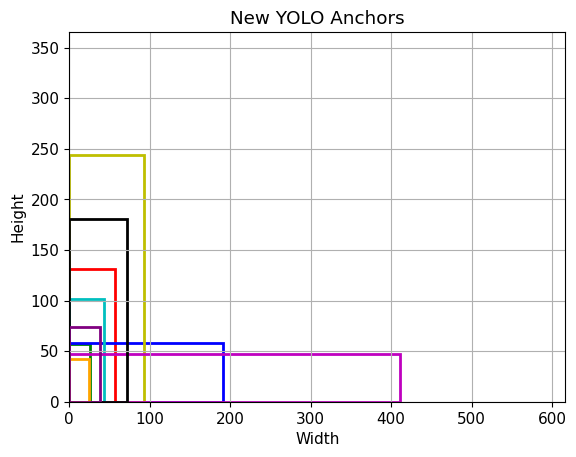

In [4]:
import json
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# JSON 파일 로드
with open('KAIST_annotation.json', 'r') as f:
    data = json.load(f)

# 바운딩 박스 데이터 추출
bounding_boxes = []
for ann in data['annotations']:
    bbox = ann['bbox']
    width = bbox[2]
    height = bbox[3]
    bounding_boxes.append([width, height])

bounding_boxes = np.array(bounding_boxes)

# K-Means 클러스터링을 사용하여 최적의 anchor 찾기
num_anchors = 9  # 원하는 anchor 개수
kmeans = KMeans(n_clusters=num_anchors, random_state=0).fit(bounding_boxes)
anchors = kmeans.cluster_centers_

# anchor 결과 출력
print("새로운 anchor:", anchors)

# anchor 시각화
fig, ax = plt.subplots()
colors = ['r', 'g', 'b', 'y', 'c', 'm', 'k', 'orange', 'purple']
for i, anchor in enumerate(anchors):
    rect = plt.Rectangle((0, 0), anchor[0], anchor[1], fill=False, edgecolor=colors[i], linewidth=2)
    ax.add_patch(rect)

plt.xlim(0, max(anchors[:, 0]) * 1.5)
plt.ylim(0, max(anchors[:, 1]) * 1.5)
plt.xlabel('Width')
plt.ylabel('Height')
plt.title('New YOLO Anchors')
plt.grid()
plt.show()


## Sanity check: dataset
- Read images and label
- Visualize bounding boxes

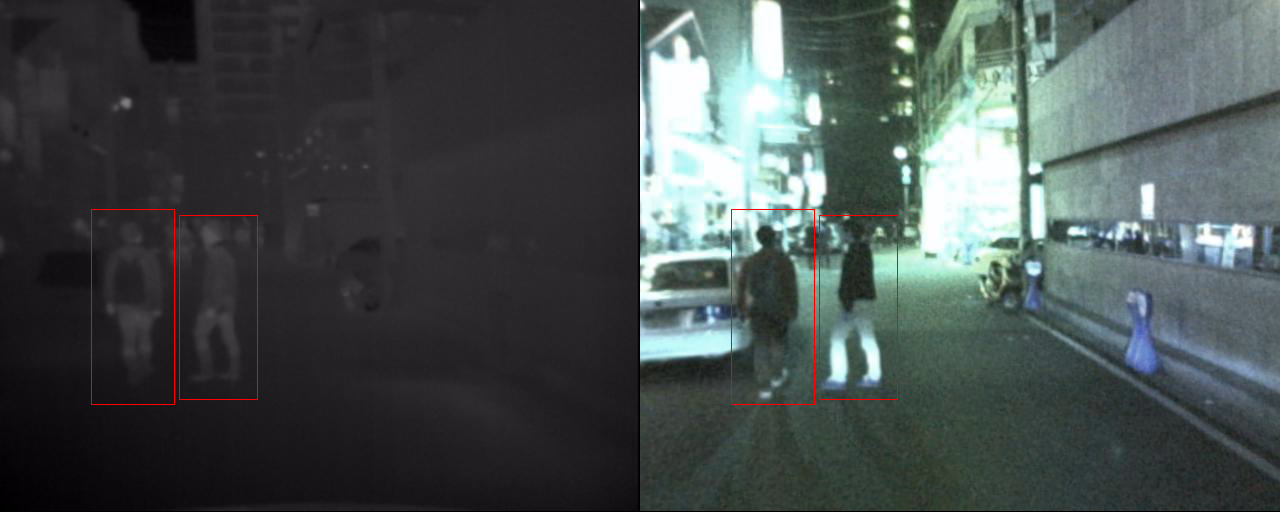

In [4]:
import cv2
import os
import numpy as np
from PIL import Image

annFile = 'datasets/kaist-rgbt/train/labels/set05_V000_I01219.txt'
lwirFile = annFile.replace('labels', 'images/lwir').replace('.txt', '.jpg')
visFile  = annFile.replace('labels', 'images/visible').replace('.txt', '.jpg')

# Read images
img_lwir = cv2.imread(lwirFile)
img_vis  = cv2.imread(visFile)

h, w = img_vis.shape[:2]

# Read labels
with open(annFile, 'r') as fp:
    labels = [x.split() for x in fp.read().strip().splitlines() if len(x)]

colors = {
    0: (255, 0, 0),
    1: (0, 255, 0),
    2: (0, 0, 255),
    3: (255, 0, 255),
}

if len(labels):
    # convert normalized bbox to pixel coordinates
    labels = np.array(labels, dtype=np.float32)
    labels[:, (1, 3)] *= w
    labels[:, (2, 4)] *= h

    cls = labels[:, 0]

    xyxy = np.zeros((len(labels), 4))
    xyxy[:, :2] = labels[:, 1:3]
    xyxy[:, 2:] = labels[:, 1:3] + labels[:, 3:5]
    xyxy = xyxy.astype(np.int16)

    for c, bb in zip(cls, xyxy):
        color = colors[c]
        cv2.rectangle(img_lwir, bb[:2], bb[2:], color)
        cv2.rectangle(img_vis,  bb[:2], bb[2:], color)

images = np.concatenate([img_lwir, img_vis], axis=1)
Image.fromarray(images)

## Sanity check: dataset class
- Visualize bounding boxes from dataset class

In [5]:
from utils.dataloaders import create_dataloader
from utils.general import check_img_size, colorstr

imgsz = 640
batch_size = 1
single_cls = False
seed = 0

train_path = data_dict["train"]
gs = max(int(model.stride.max()), 32)  # grid size (max stride)
imgsz = check_img_size(imgsz, gs, floor=gs * 2)  # verify imgsz is gs-multiple

train_loader, dataset = create_dataloader(
    train_path,
    imgsz,
    batch_size,
    gs,
    single_cls,
    hyp=hyp,
    augment=False,      # TODO: check if there is no bug when applying augmentation
    cache=None,
    rect=False,
    rank=-1,
    workers=8,
    image_weights=False,
    quad=False,
    prefix=colorstr("train: "),
    shuffle=False,      # No shuffle for debugging
    seed=seed,
    rgbt_input=True,
)


train: Scanning /home/liuss98/kaist-rgbt/train.cache... 10031 images, 5636 backgrounds, 0 corrupt: 100%|██████████| 10031/10031 [00:00<?, ?it/s]


In [6]:
from utils.dataloaders import LoadRGBTImagesAndLabels
from utils.general import xywh2xyxy
import numpy as np
import cv2
from PIL import Image

# Get the size of the dataset
dataset_size = len(dataset)

# Ensure frame index is within bounds
frame = min(12112, dataset_size - 1)

# Get a minibatch (fast)
imgs, targets, paths, shapes, _ = LoadRGBTImagesAndLabels.collate_fn([dataset[frame]])

idx = 0
img_lwir = imgs[0][idx].numpy().transpose((1, 2, 0))
img_vis = imgs[1][idx].numpy().transpose((1, 2, 0))
h, w = img_vis.shape[:2]

labels = targets.numpy()

colors = {
    0: (255, 0, 0),
    1: (0, 255, 0),
    2: (0, 0, 255),
    3: (255, 0, 255),
}

if len(labels):
    labels = labels[labels[:, 0] == idx, 1:]

    # Convert normalized bbox to pixel coordinates
    labels = np.array(labels, dtype=np.float32)
    labels[:, (1, 3)] *= w
    labels[:, (2, 4)] *= h

    cls = labels[:, 0]

    xyxy = xywh2xyxy(labels[:, 1:5])
    xyxy = xyxy.astype(np.int16)

    img_lwir = np.ascontiguousarray(img_lwir)
    img_vis = np.ascontiguousarray(img_vis)

    for c, bb in zip(cls, xyxy):
        color = colors[int(c)]
        cv2.rectangle(img_lwir, bb[:2], bb[2:], color)
        cv2.rectangle(img_vis, bb[:2], bb[2:], color)

images = np.concatenate([img_lwir, img_vis], axis=1)
print(paths[idx])
Image.fromarray(images).show()


datasets/kaist-rgbt/train/images/{}/set05_V000_I02919.jpg


## Run trained model
- Visualize bounding boxes from dataset class

In [7]:
import torch
from models.yolo import Model
from utils.torch_utils import select_device

weights = 'kaist-rgbt_best.pt'      # Train your own model!
data = 'data/kaist-rgbt.yaml'
cfg = 'models/yolov5s_kaist-rgbt.yaml'
hyp = 'data/hyps/hyp.scratch-low.yaml'
nc = 1
half = False  # use FP16 half-precision inference
dnn = False  # use OpenCV DNN for ONNX inference
device = select_device('cpu')

with open(hyp, errors="ignore") as f:
    hyp = yaml.safe_load(f)  # load hyps dict

model = Model(cfg, ch=3, nc=nc, anchors=hyp.get("anchors")).to(device)  # create

# inference
model.eval()
ims = [im.to(device, non_blocking=True).float() / 255 for im in imgs]    # For RGB-T input
with torch.no_grad():
    pred = model(ims)  # forward

YOLOv5 🚀 56adb87 Python-3.10.14 torch-2.3.1+cu121 CPU


                 from  n    params  module                                  arguments                     
  0                -1  1      7040  models.common.MultiStreamConv           [3, 32, 6, 2, 2]              
  1                -1  1     37120  models.common.MultiStreamConv           [32, 64, 3, 2]                
  2                -1  1     37632  models.common.MultiStreamC3             [64, 64, 1]                   
  3                -1  1         0  models.common.Fusion                    ['concat', 2]                 
  4                -1  1     16640  models.common.Conv                      [128, 128, 1, 1]              
  5                -1  1    147712  models.common.Conv                      [128, 128, 3, 2]              
  6                -1  2    115712  models.common.C3                        [128, 128, 2]                 
  7                -1  1    295424  models.common.Conv                      [128, 256, 3

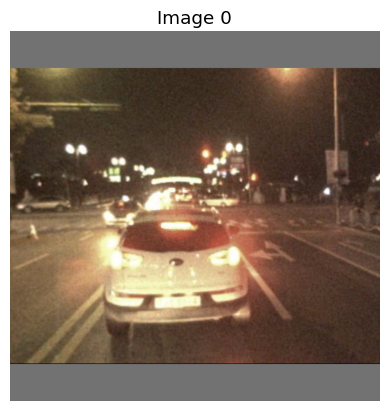

In [8]:
import torch
from models.yolo import Model
from utils.torch_utils import select_device
from utils.general import non_max_suppression, scale_boxes, xyxy2xywh
from utils.plots import Annotator, colors
from pathlib import Path
import yaml
import cv2
import numpy as np
from PIL import Image

conf_thres = 0.25  # confidence threshold
iou_thres = 0.45  # NMS IOU threshold
max_det = 1000  # maximum detections per image
classes = None
agnostic_nms = False  # class-agnostic NMS

pred = non_max_suppression(pred, conf_thres, iou_thres, classes, agnostic_nms, max_det=max_det)

# Resize predicted box
# scale_boxes()         # see valpy:L285

# [TODO] draw predictions (see detect.py:L178)

# Process predictions
# 예측값 처리
for i, det in enumerate(pred):  # 각 이미지의 예측값에 대해 반복
    # RGB 이미지를 로드 (imgs[1]이 RGB 이미지라고 가정)
    im0 = imgs[1][i].numpy().transpose((1, 2, 0))  # (H, W, C) 형식으로 변환
    im0 = np.ascontiguousarray(im0)  # 메모리에서 연속된 배열로 변환
    
    # Annotator 초기화 (바운딩 박스와 라벨을 그리기 위해)
    annotator = Annotator(im0, line_width=3, example=str(nc))

    if len(det):  # 예측값이 있는 경우
        # 모델 입력 크기에서 원본 이미지 크기로 상자 크기 조정
        det[:, :4] = scale_boxes(ims[i].shape[1:], det[:, :4], im0.shape).round()

        # 각 예측값 그리기
        for *xyxy, conf, cls in reversed(det):  # 각 예측값에 대해 반복
            c = int(cls)  # 클래스 번호를 정수로 가져오기
            label = f'{c} {conf:.2f}'  # 클래스와 신뢰도 라벨 생성
            annotator.box_label(xyxy, label, color=colors(c, True))  # 상자와 라벨 그리기

    # 최종 주석 이미지 가져오기
    im0 = annotator.result()
    
    # matplotlib를 사용하여 이미지 표시
    plt.imshow(im0)
    plt.title(f"Image {i}")
    plt.axis('off')
    plt.show()



In [9]:
pred[0]

tensor([], size=(0, 6))

[3273473:3273473:0625/171551.358063:ERROR:viz_main_impl.cc(198)] Exiting GPU process due to errors during initialization
Deserialization failed!
Deserialization failed!
